# Effect of Forcings on CAMELs Simulations

[HydroShare Resource Link](https://www.hydroshare.org/resource/c75ad34da9d642aca6e51126bfff45d1/)

Now we can look at the output and see which forcing variables have the most error. This code is meant to be run on the subset of basins that the ensembles of different model decisions were run on in the `camels_pysumma.ipynb` notebook. This notebook will not run all the way through if the ensembles were not created.

Load the imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray as xr
import os

<br>

### You will need to edit these paths to be your folders

<br>
Keep these the same.

In [2]:
top_folder = os.path.join(os.getcwd(), 'summa_camels')
settings_folder = os.path.join(top_folder, 'settings.v1')

<br>

### Make problem complexity choices here:

In the notebook `camels_pysumma.ipynb` you decided if you wanted to run: 
 - `default_prob = 1`: the default configuration with the parameters you have.
 - `lhc_prob = 1`: the default configuration with exploration of the parameter space.
 - `lhc_config_prob = 1`: 8 different configurations (choices that have been seen to affect the model output in previous research) with exploration of the parameter space.
 
DO NOT choose one of these to be one here if you did not choose it to be one before.

Again, you can choose all of these to be 1, but each step of complexity will contain the previous problem(s), so it is not necessary. In this notebook it will not make a diffence in the output.

In [3]:
default_prob = 0
lhc_prob = 0
lhc_config_prob = 1

## Manipulating the Configuration of the pySUMMA Objects

Let's look at some error metrics by HRU, starting with the default paramaters and default configuration.
KGE means perfect agreement if it is 1, and <0 means the mean is a better guess. 
Bias means perfect aggreement if it is 0, and larger means larger error. 
All data have a small number added so we don't divide by 0. 

In [4]:
# Define truth data set
if lhc_config_prob==1: 
    suffix = '_configs_latin.nc'
    default_name = '++BallBerry++0'
    lat_name = [default_name[:-1]+str(i) for i in range(0,2)]
elif lhc_prob==1:
    suffix = '_latin.nc'
    default_name = '0'  
    lat_name = [str(i) for i in range(0,2)]
elif default_prob==1:
    suffix = '_hru.nc'
    default_name = 'default'      
sim_truth = xr.open_dataset(top_folder+'/output/merged_day/NLDAStruth'+suffix)

In [5]:
# get number of HRUs and small add
attrib = xr.open_dataset(top_folder+'/settings.v1/attributes.nc')
the_hru = np.array(attrib['hruId'])
small_add = 1e-10 # so no zeros

In [6]:
# Set forcings and create dictionaries
forc_sim= ['windspd','SWRadAtm','spechum','pptrate', 'LWRadAtm','airtemp','airpres']
comp_sim=['scalarSurfaceRunoff','scalarAquiferBaseflow','scalarInfiltration','scalarRainPlusMelt','scalarSoilDrainage',
          'scalarLatHeatTotal','scalarSenHeatTotal','scalarSnowSublimation',
          'scalarSWE',
          'scalarCanopyWat',
          'scalarNetRadiation','scalarTotalET','scalarTotalRunoff','scalarTotalSoilWat']
var_sim = np.concatenate([forc_sim, comp_sim])

In [7]:
col1 = ['c','m','orange','b','g','r','gray']

In [8]:
# definitions for KGE computation
def covariance(x,y,dims=None):
    return xr.dot(x-x.mean(dims), y-y.mean(dims), dims=dims) / x.count(dims)

def correlation(x,y,dims=None):
    return (covariance(x,y,dims)) / (x.std(dims) * y.std(dims))

In [9]:
if lhc_prob==1 or lhc_config_prob==1: decision_set = np.array(sim_truth['decision']) 
else: decision_set = np.array('default')
#get names off the files
decision_set = np.array(sim_truth['decision']) 

In [10]:
# set up xarray
hrud = sim_truth['hru'] #indices here are 0 to number of basins
shape = ( len(decision_set),len(hrud), len(forc_sim))
dims = ('decision','hru','var')
coords = {'decision':decision_set,'hru': hrud, 'var':forc_sim}
error_data = xr.Dataset(coords=coords)
for s in comp_sim:
    error_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

<br>
Now run the actual computations on KGE. 
This takes 6 minutes on 4 HRUs for the lhc_config problem, and less for the smaller problems. 

In [11]:
%%time
truth0_0 = sim_truth.drop_vars('hruId').load()
for v in forc_sim:
    truth = truth0_0
    #truth = truth.isel(time = slice(365*24,(365*6+2)*24))+small_add #don't include first year, 5 years
    truth = truth.isel(time = slice(0,365*24*2))+small_add 
    sim = xr.open_dataset(top_folder+'/output/merged_day/NLDASconstant_' + v + suffix)
    sim = sim.drop_vars('hruId').load()
    #sim = sim.isel(time = slice(365*24,(365*6+2)*24))+small_add #don't include first year, 5 years
    sim = sim.isel(time = slice(0,365*24*2))+small_add
    r = sim.mean(dim='time') #to set up xarray since xr.dot not supported on dataset and have to do loop
    for s in var_sim:         
        r[s] = correlation(sim[s],truth[s],dims='time')
    ds = 1 - np.sqrt( np.square(r-1) 
        + np.square( sim.std(dim='time')/truth.std(dim='time') - 1) 
        + np.square( sim.mean(dim='time')/truth.mean(dim='time') - 1) )
    ds0 = ds.load()
    for s in comp_sim:
        error_data[s].loc[:,:,v]  = ds0[s]
    print(v)

windspd
SWRadAtm
spechum
pptrate
LWRadAtm
airtemp
airpres
CPU times: user 30.4 s, sys: 2.41 s, total: 32.8 s
Wall time: 32.8 s


<br>

Now summarize this by totals over all output variables and each output variable, and ranks each constant forcing from most error to least error.

In [12]:
# setup summaries by simulated output variable
summ_kind = ['total','rank']
shape = (len(decision_set),len(hrud),len(forc_sim),len(summ_kind))
dims = ('decision','hru','var','summary')
coords = {'decision':decision_set,'hru': the_hru, 'var': forc_sim,'summary':summ_kind}
rank_data = xr.Dataset(coords=coords)
rank_data['all'] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name='all')
for s in comp_sim:
    rank_data[s] = xr.DataArray(data=np.full(shape, np.nan),
                                 coords=coords, dims=dims,
                                 name=s)

In [13]:
# calculate sums of KGE and ranks of worst to best forcing for error over all variables
ds = error_data
ds =ds.fillna(0) # So don't add to total KGE    
ds1 = ds.loc[dict(var = forc_sim)]
ds1 = ds1.where(ds1>-1,-1) #make the very negative values be -1
ds2 = sum(d for d in ds1.data_vars.values())
rank_data['all'].loc[:,:,:,'total'] = ds2.values
rank_data['all'].loc[:,:,:,'rank'] = ds2.rank(dim='var').values
for s in comp_sim:
    rank_data[s].loc[:,:,:,'total'] = ds1[s].values
    rank_data[s].loc[:,:,:,'rank'] = ds1[s].rank(dim='var').values

<br>
Let's first look at the error as a total over the simulated variables (14 of them not including the forcings), with just the default parameters and configurations. Each row is a basin here, and the worse the KGE (more error) the shorter the bar. KGE does not need to be normalized. We plot the HRU error as stack of values, with no error plotting as a height of 1 for that color. Values less than 0 are plotted as 0. 

In [14]:
# Setup plots
y = np.arange(len(hrud))
col_forc = col1
letter = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
wid = np.ceil(len(var_sim)/3)
inc = np.floor(len(hrud)/10)
if inc<1: inc=1
ytic = np.arange(0, len(hrud),inc).tolist()
ytic =[int(i) for i in ytic]
ytics =[str(i) for i in ytic]
labels =["V"+i for i in ytics]

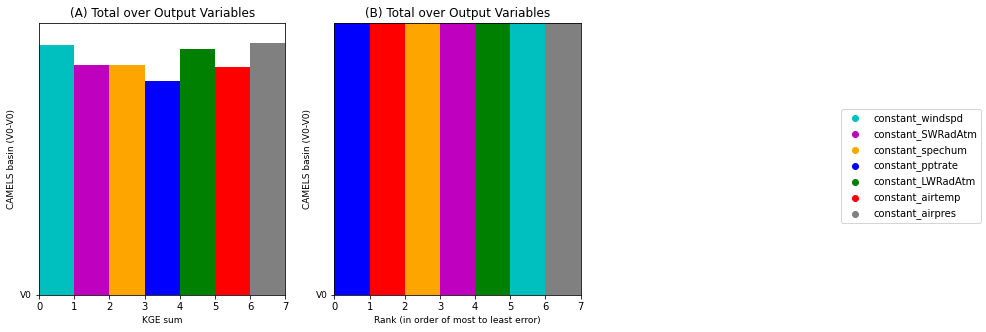

CPU times: user 490 ms, sys: 27.9 ms, total: 518 ms
Wall time: 518 ms


In [15]:
%%time
wid = len(summ_kind)+1
plot1 = plt.figure(1, figsize = (15,5))
for i, t in enumerate(summ_kind):  
    plot2 = plt.subplot(1,wid,i+1)
    data = rank_data['all'].loc[default_name,:,:,t]    
    for j, v in enumerate(forc_sim):
        if t=='total': plt.bar(height = data.loc[:,v]/14, x = j+.5, width = 1.0, color = col_forc[j], bottom = y)
        if t=='rank': plt.bar(height = 1, x = data.loc[:,v]-0.5, width = 1.0, color = col_forc[j], bottom = y)

    plt.title('('+letter[i]+') '+'Total over Output Variables')
    plt.xlim(0,len(forc_sim))       
    plt.ylim(0,len(ytic))   
    plt.yticks(ytic, labels, fontsize = 9)
    plt.xticks(np.arange(0, len(forc_sim)+.01, 1).tolist())
    plt.tick_params(axis = "y", which = "both", bottom = False, top = False)
    plt.ylabel("CAMELS basin ("+labels[0]+"-"+labels[-1]+")", fontsize = 9)
    if t=='total': word = "KGE sum"
    if t=='rank': word = "Rank (in order of most to least error)"
    plt.xlabel(word, fontsize = 9)

plt.subplots_adjust(hspace = .4)

for j, v in enumerate(forc_sim):
    plt.scatter([],[], color = col_forc[j], label = 'constant_' +  v)
plt.figlegend(loc = 'center right')
plt.show()

<br>

Constant air pressure has almost a perfect KGE in the example basins. Now look at it by simulated variable instead of total. 

/opt/conda/envs/pysumma/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


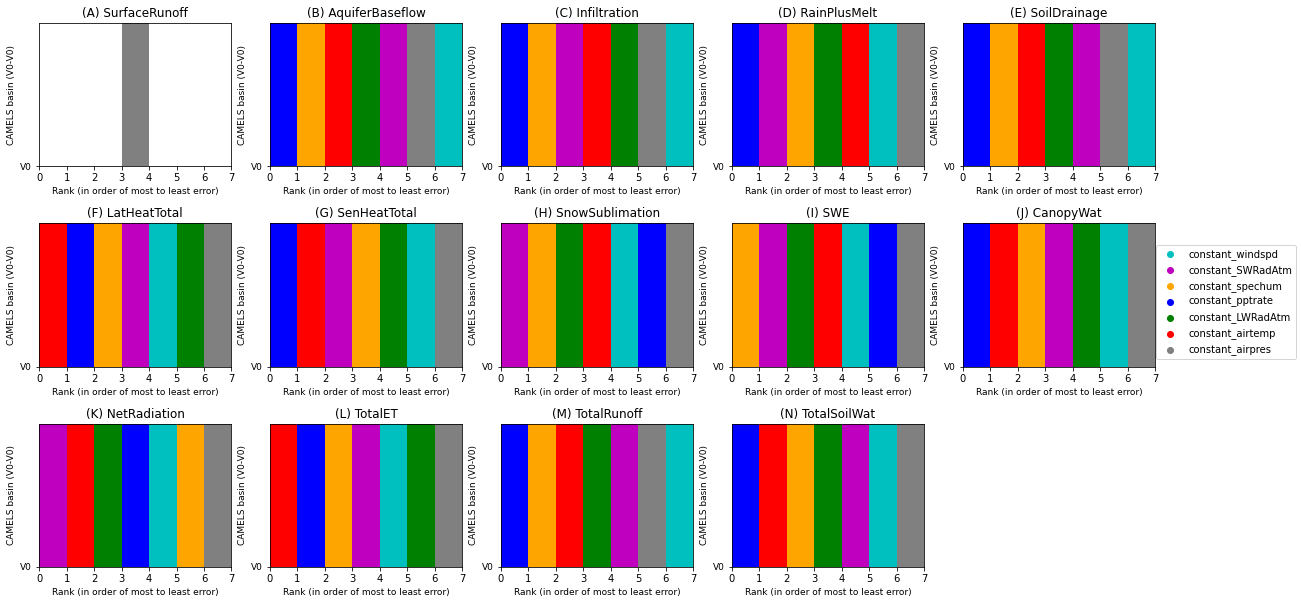

CPU times: user 1.88 s, sys: 67.3 ms, total: 1.95 s
Wall time: 1.95 s


In [16]:
%%time
wid = np.ceil(len(comp_sim)/3)
plot1 = plt.figure(1, figsize = (20,10))

for i, s in enumerate(comp_sim):
    data = rank_data[s].loc[default_name,:,:,'rank']  
    plot2 = plt.subplot(3,wid,i+1)
    for j, v in enumerate(forc_sim):
        plt.bar(height = 1, x = data.loc[:,v]-0.5, width = 1.0, color = col_forc[j], bottom = y)
    
    plt.title('('+letter[i]+') '+s[6:])
    plt.xlim(0,len(forc_sim))       
    plt.ylim(0,len(ytic))   
    plt.yticks(ytic, labels, fontsize = 9)
    plt.xticks(np.arange(0, len(forc_sim)+.01, 1).tolist())
    plt.tick_params(axis = "y", which = "both", bottom = False, top = False)
    plt.ylabel("CAMELS basin ("+labels[0]+"-"+labels[-1]+")", fontsize = 9)
    word = "Rank (in order of most to least error)"
    plt.xlabel(word, fontsize = 9)

plt.subplots_adjust(hspace = .4)

for j, v in enumerate(forc_sim):
    plt.scatter([],[], color = col_forc[j], label = 'constant_' +  v)
plt.figlegend(loc = 'center right')
plt.show()

<br>

Now we add up the HRUs that have each forcing ranked as 1, 2, ... 7, sequentially for each simulated variable, and plot it as number of HRUS at with a forcing at each ranking. We normalize the sum of the number of HRUs by the number counted, so if there are ties in an HRU's rankings, there will be a fewer HRUs in the count. For example, if their is no Surface Runoff for an HRU with a particular decision, all forcings will result in a perfect KGE of 1, and all will be ranked as 4. Thus, the Rank 1 plot will not have a contribution from this HRU. 

In [17]:
# Setup plots
wid = len(forc_sim)
tal = len(comp_sim)
ndec = 1
config_num = 1
x = np.arange(ndec)
inc = np.floor(ndec/config_num)
if inc<1: inc=1
xtic = np.arange(0, ndec,inc).tolist()
xtic =[int(i) for i in xtic]
xtics =[str(i+1) for i in xtic]
labels =["D"+i for i in xtics]

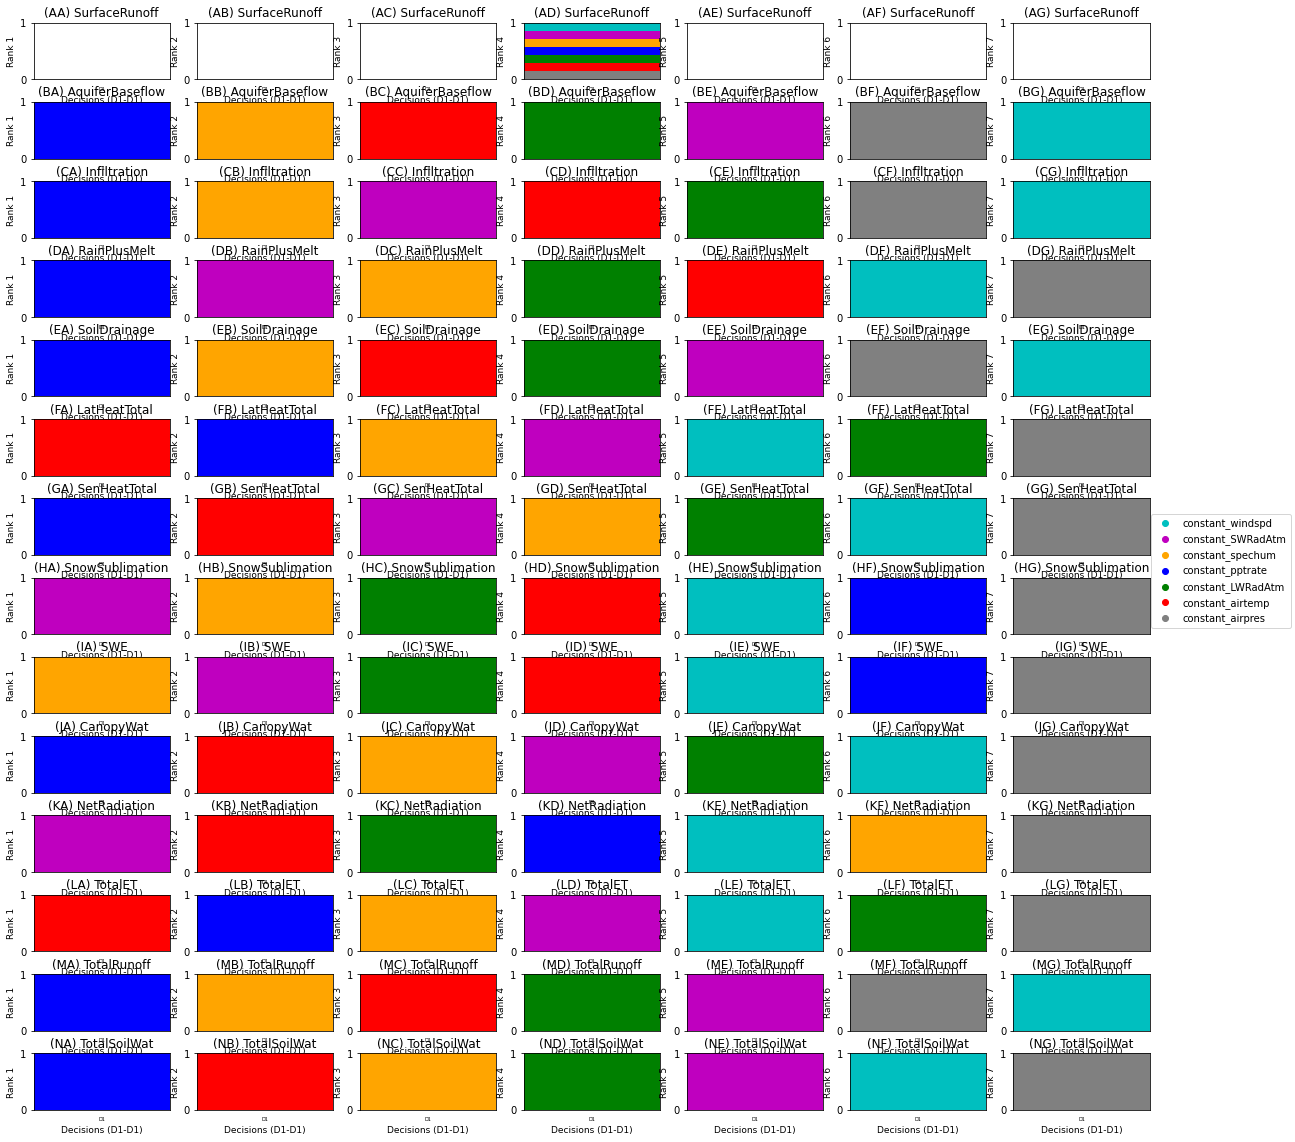

CPU times: user 11.5 s, sys: 251 ms, total: 11.7 s
Wall time: 11.7 s


In [18]:
%%time
plot1 = plt.figure(1, figsize = (20,20))

for i, s in enumerate(comp_sim):
    for j in np.arange(len(forc_sim)):
        plot2 = plt.subplot(tal,wid,i*wid+j+1)
      
        data = rank_data[s].loc[default_name,:,:,'rank']
        data = data.where(data==j+1)/(j+1)
        data = data.sum(dim='hru')
        data = data/data.sum(dim='var')*len(hrud)
        data_Master = [0] * ndec
        for jj, v in enumerate(reversed(forc_sim)):
            plt.bar(height = data.loc[v], x = x, width = 1.0, color = col_forc[-jj-1], bottom = data_Master)
            data_Master = data_Master+data.loc[v].values
            
        plt.title('('+letter[i]+letter[j]+') '+s[6:])
        plt.xlim(-0.5,ndec-0.5)
        plt.ylim(0,len(hrud))
        plt.xticks(xtic, labels, fontsize = 5)
        plt.yticks(np.arange(0, len(hrud)+.01, 1).tolist())
        plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
        plt.xlabel("Decisions ("+labels[0]+"-D"+str(ndec)+")", fontsize = 9)
        plt.ylabel("Rank "+str(j+1), fontsize = 9)

        plt.subplots_adjust(hspace = .4)

for j, v in enumerate(forc_sim):
    plt.scatter([],[], color = col_forc[j], label = 'constant_' +  v)
plt.figlegend(loc = 'center right')
plt.show()

## Differences in Parameter Space and Model Configuration

We can plot the summation patterns plotted earlier for each decision. A decision is a combination of Latin Hypercube parameter set and model configuration choice. We plot blocks of model configurations on the x-axis, so each configuration has 11 LHC parameter sets associated with it for 11 vertical bars with each. If the model configurations were run, there are 8 configurations. Based on the paper results, we might expect to see more differences across model configurations but not many across the parameter space. So, every block of 11 parameter sets will set itself somewhat apart. First, we just plot the default model configuration. The default parameters will show up as the first parameter set. 

In [19]:
# Setup plots
if lhc_prob==1 or lhc_config_prob==1:
    wid = len(forc_sim)
    tal = len(comp_sim)
    ndec = 2
    config_num = ndec/2
    x = np.arange(ndec)
    inc = np.floor(ndec/config_num)
    if inc<1: inc=1
    xtic = np.arange(0, ndec,inc).tolist()
    xtic =[int(i) for i in xtic]
    xtics =[str(i+1) for i in xtic]
    labels =["D"+i for i in xtics]

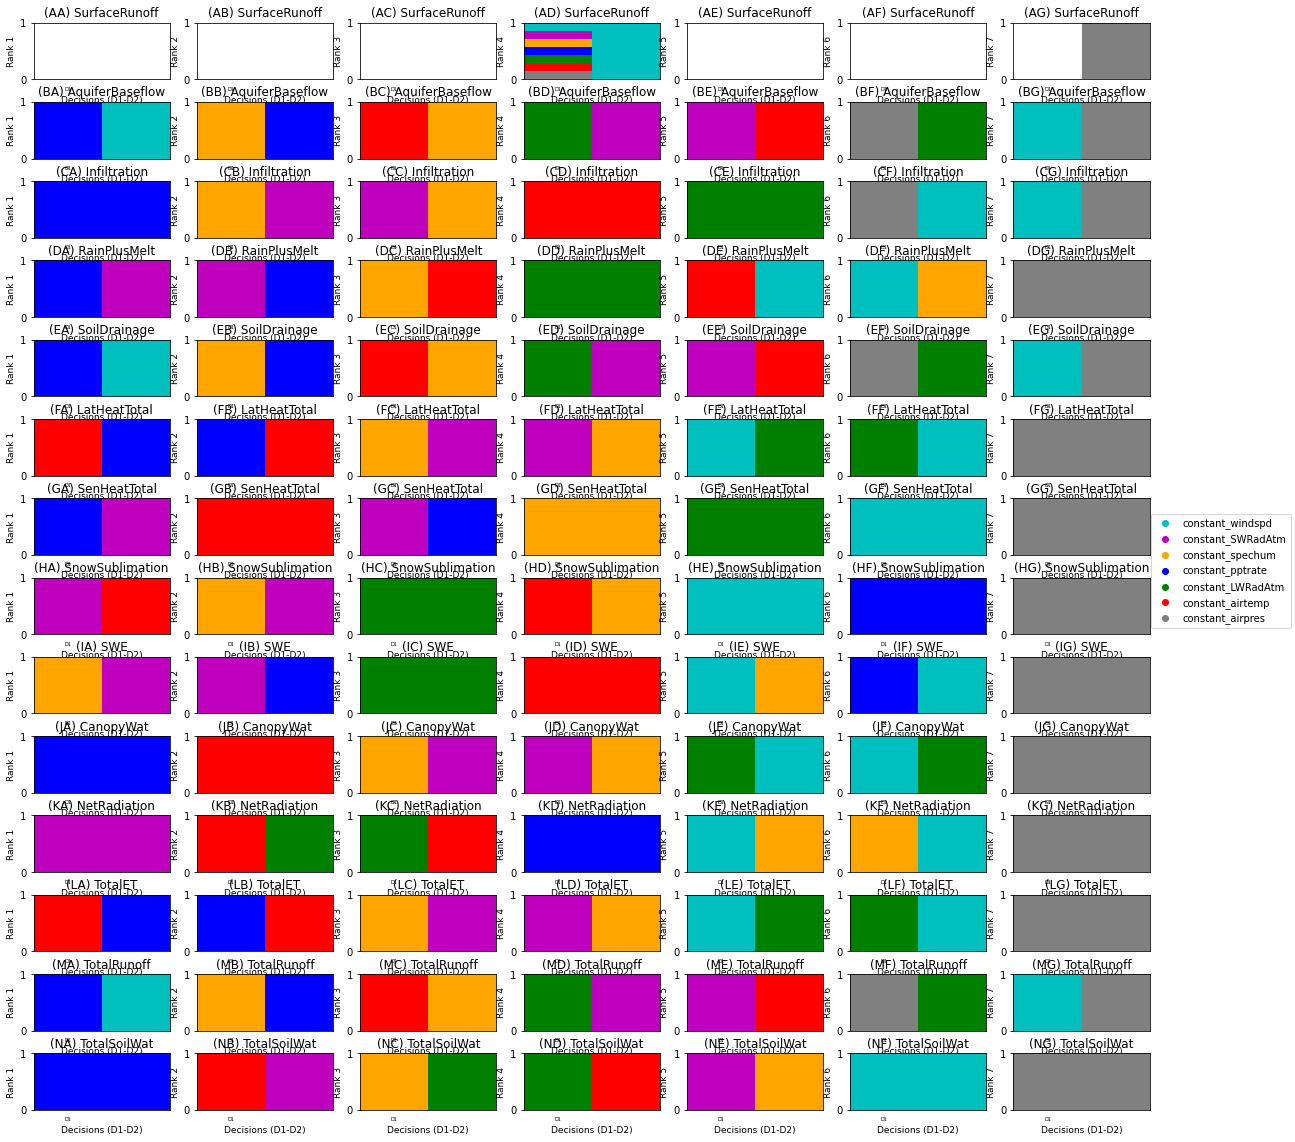

CPU times: user 15.2 s, sys: 308 ms, total: 15.5 s
Wall time: 15.5 s


In [20]:
%%time
if lhc_prob==1 or lhc_config_prob==1:
    plot1 = plt.figure(1, figsize = (20,20))

    for i, s in enumerate(comp_sim):
        for j in np.arange(len(forc_sim)):
            plot2 = plt.subplot(tal,wid,i*wid+j+1)

            data = rank_data[s].loc[lat_name,:,:,'rank']
            data = data.where(data==j+1)/(j+1)
            data = data.sum(dim='hru')
            data = data/data.sum(dim='var')*len(hrud)
            data_Master = [0] * ndec
            for jj, v in enumerate(reversed(forc_sim)):
                plt.bar(height = data.loc[:,v], x = x, width = 1.0, color = col_forc[-jj-1], bottom = data_Master)
                data_Master = [m + n for m, n in zip(data_Master, data.loc[:,v])]

            plt.title('('+letter[i]+letter[j]+') '+s[6:])
            plt.xlim(-0.5,ndec-0.5)
            plt.ylim(0,len(hrud))
            plt.xticks(xtic, labels, fontsize = 5)
            plt.yticks(np.arange(0, len(hrud)+.01, 1).tolist())
            plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
            plt.xlabel("Decisions ("+labels[0]+"-D"+str(ndec)+")", fontsize = 9)
            plt.ylabel("Rank "+str(j+1), fontsize = 9)

            plt.subplots_adjust(hspace = .4)

    for j, v in enumerate(forc_sim):
        plt.scatter([],[], color = col_forc[j], label = 'constant_' +  v)
    plt.figlegend(loc = 'center right')
    plt.show()

<br>
Now, if we calculated it, we can plot the full problem with all model configurations. The default will show up as block 4. 

In [21]:
# Setup plots
if lhc_config_prob==1:
    wid = len(forc_sim)
    tal = len(comp_sim)
    ndec = len(decision_set)
    config_num = ndec/11
    x = np.arange(ndec)
    inc = np.floor(ndec/config_num)
    if inc<1: inc=1
    xtic = np.arange(0, ndec,inc).tolist()
    xtic =[int(i) for i in xtic]
    xtics =[str(i+1) for i in xtic]
    labels =["D"+i for i in xtics]

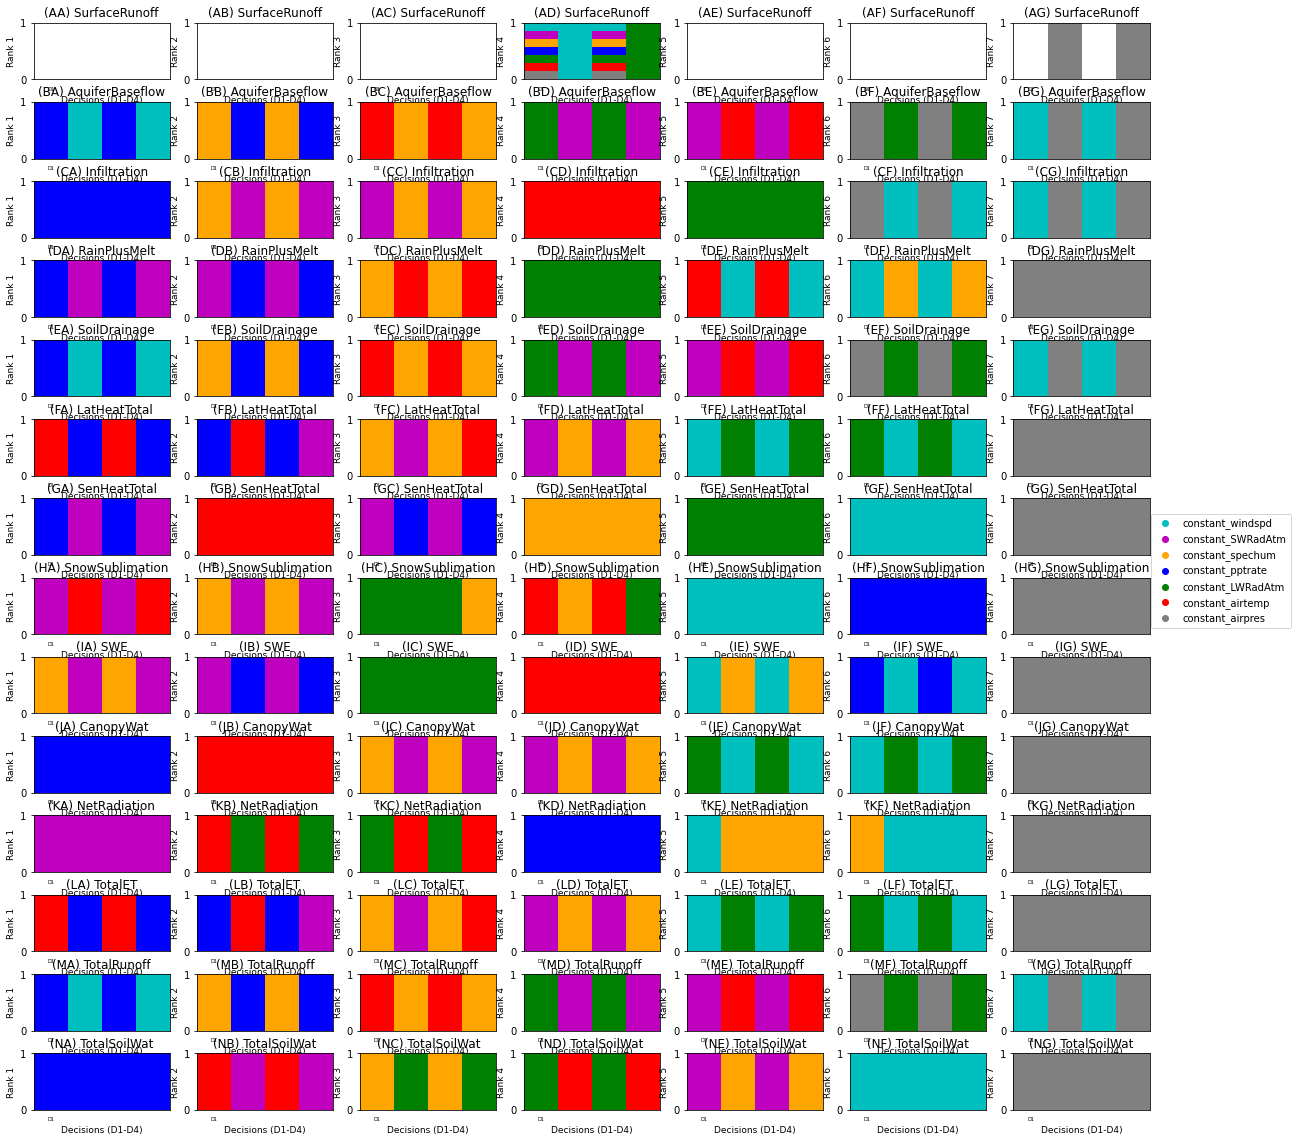

CPU times: user 20.2 s, sys: 295 ms, total: 20.5 s
Wall time: 20.5 s


In [22]:
%%time
if lhc_config_prob==1:
    plot1 = plt.figure(1, figsize = (20,20))

    for i, s in enumerate(comp_sim):
        for j in np.arange(len(forc_sim)):
            plot2 = plt.subplot(tal,wid,i*wid+j+1)

            data = rank_data[s].loc[:,:,:,'rank']
            data = data.where(data==j+1)/(j+1)
            data = data.sum(dim='hru')
            data = data/data.sum(dim='var')*len(hrud)
            data_Master = [0] * ndec
            for jj, v in enumerate(reversed(forc_sim)):
                plt.bar(height = data.loc[:,v], x = x, width = 1.0, color = col_forc[-jj-1], bottom = data_Master)
                data_Master = [m + n for m, n in zip(data_Master, data.loc[:,v])]

            plt.title('('+letter[i]+letter[j]+') '+s[6:])
            plt.xlim(-0.5,ndec-0.5)
            plt.ylim(0,len(hrud))
            plt.xticks(xtic, labels, fontsize = 5)
            plt.yticks(np.arange(0, len(hrud)+.01, 1).tolist())
            plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
            plt.xlabel("Decisions ("+labels[0]+"-D"+str(ndec)+")", fontsize = 9)
            plt.ylabel("Rank "+str(j+1), fontsize = 9)

            plt.subplots_adjust(hspace = .4)

    for j, v in enumerate(forc_sim):
        plt.scatter([],[], color = col_forc[j], label = 'constant_' +  v)
    plt.figlegend(loc = 'center right')
    plt.show()